In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import wrapper
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [2]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_cafe = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cafe.zarr"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoPym_HOT_CAFE_by_epi_layer_depth"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 322kB
Dimensions:              (latitude: 1, longitude: 1, time: 1827, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-01 ... 2010-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 44kB 24.7...
    U                    (latitude, longitude, time, depth) float64 44kB -0.0...
    V                    (latitude, longitude, time, depth) float64 44kB 0.15...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2904 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.8233 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.403 ... 1...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.5779 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.79 ... 0....
    npp                  (latitude, longitude, time) float64 15kB 221.1 ... 3...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 44kB 107....
    zeu                  (latitude, longitude, time) float64 15kB 71.63 ... 7...
    zooc                 (latitude, longitude, time) float64 15kB 0.2527 ... ...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth


Magnitude,[[[107.43817318960242 107.62027138586784 111.3608022247511 ... 122.58406536705469 117.0609769555549 112.42833201753643]]]
Units,meter


## CAFE npp


In [6]:
cafe_npp = xr.open_dataset(path_to_cafe, engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
cafe_npp.load()

<xarray.Dataset> Size: 29kB
Dimensions:    (time: 1827, latitude: 1, longitude: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 15kB 2005-01-01 2005-01-02 ... 2010-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 15kB 349.7 353.3 ... 310.1
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, layer=0, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations

Magnitude,[[[129.6241254518878]] [[241.93912957042275]] [[226.49606461724028]] [[297.7116912786574]] [[338.10901943263667]] [[348.62482773763463]] [[414.2199967520759]] [[380.37086633863925]] [[310.58447115849805]] [[299.6403565698716]] [[286.7338167009678]] [[203.04283404086257]] [[182.27868432749716]] [[213.14200856879958]] [[158.16330671375027]] [[213.21478647165335]] [[192.88052379372309]] [[178.96047463029464]] [[192.29199558308798]] [[279.3417600824082]] [[245.83409341816906]] [[251.6896388460537]] [[321.7758900737953]] [[240.68806733748397]] [[285.6867904967255]] [[135.38561733182783]] [[184.07910842756385]] [[113.49811752766878]] [[114.75328020306664]] [[291.8373150586662]] [[208.07113611154097]] [[265.3864805985914]] [[300.52656827637287]] [[405.7243428475462]] [[317.43793038041196]] [[289.488862617321]] [[369.70092582568174]] [[402.38246906464065]] [[187.91756194824]] [[276.50283391179846]] [[168.86156744783952]] [[165.310175828319]] [[209.0217472434997]] [[153.79359135232633]] [[105.69203672669539]] [[121.46032471801634]] [[136.65611305691513]] [[277.11358627957645]] [[401.3576646611965]] [[290.014536521321]] [[295.556652170673]] [[250.23021884103585]] [[157.9912873050357]] [[222.38519479834522]] [[49.59509397421906]] [[179.40468654130052]] [[203.9030493018046]] [[146.13778456973913]] [[416.76577798207774]] [[145.61375062461659]] [[148.20915222988242]] [[377.87205331539525]] [[188.7746322496145]] [[115.03212441610059]] [[207.35448677619334]]]
Units,milligram/meter2
Magnitude,[[[311.2660665468461]] [[411.04654946953013]] [[434.4442853402015]] [[410.12685963930767]] [[425.9698605032181]] [[450.29322697950903]] [[549.8204501288825]] [[601.5568977313856]] [[320.1690029650057]] [[442.99388134444786]] [[355.67831022742035]] [[300.9947612036864]] [[283.66585739301]] [[276.6976430774046]] [[298.1719638965375]] [[402.4179423232029]] [[319.81105274836926]] [[456.9291939233906]] [[346.7687289469165]] [[437.89634413936665]] [[418.59746747308213]] [[295.20449865110794]] [[388.1953942339221]] [[303.2075888481008]] [[435.41244496878386]] [[362.61171823731013]] [[325.9052064916851]] [[237.661578428888]] [[197.9773531469736]] [[410.85341661483824]] [[497.50541412129627]] [[341.6489013266257]] [[547.9308393854859]] [[524.742692424872]] [[504.8848192812326]] [[495.06076671485187]] [[573.5467022569293]] [[684.5289102704819]] [[441.3022237706481]] [[389.5605894361301]] [[295.2949937401673]] [[298.6134937077826]] [[250.8035280886973]] [[192.58467512551408]] [[236.8405622245085]] [[230.718829341949]] [[296.78592909233066]] [[409.622869796669]] [[494.6507966129079]] [[410.0118725290155]] [[324.20490677308646]] [[331.816723195203]] [[479.1847643283798]] [[470.81495398792043]] [[147.90582627756717]] [[222.6260094903661]] [[253.23644332570444]] [[265.4001656739965]] [[591.1972238728096]] [[294.8439913315892]] [[541.8992237354149]] [[443.78218169671544]] [[269.09539710001894]] [[293.6753429149077]] [[306.4898301315927]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [8]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=1 / 12, timestep=1),
)

2025-01-15 12:12:58,484 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



In [9]:
parameterization = [
    [0, 0, 0.1668, 10.38, -0.11, 150, 0.15],
]

## Run simulation


In [10]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=parameterization, groups_name=["D1N1"]),
)

model_print.run()

In [11]:
model_print.state

<xarray.Dataset> Size: 182kB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 1,
                                   longitude: 1, time: 1827, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) int64 24B 0 1 2
  * latitude                      (latitude) float64 8B 22.75
  * longitude                     (longitude) int64 8B -158
  * time                          (time) datetime64[ns] 15kB 2005-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/28)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    min_temperature               (functional_group, cohort) float64 88B 21.2...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 20kB ...
    cell_area                     (latitude, longitude) float64 8B 7.918e+07
    mortality_field               (functional_group, time, latitude, longitude) float64 15kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 15kB ...
    biomass                       (functional_group, time, latitude, longitude) float64 15kB ...

## Plot


### Taylor Diagram


Convert to pandas series.


In [12]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .reset_index()
    .set_index("time")["biomass"]
)
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]


Then resample to month.


In [13]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [14]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass (VGPM npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [15]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [-0.5241706058682062, -0.48272800332596016]
norm STD [0.5803656063857013, 0.4597877823912924]
bias [-0.301645982477918, -1.5129585506396694]
NRMSE [1.3947205527000623, 1.2865883883865663]
name ['HOT Day', 'HOT Night']


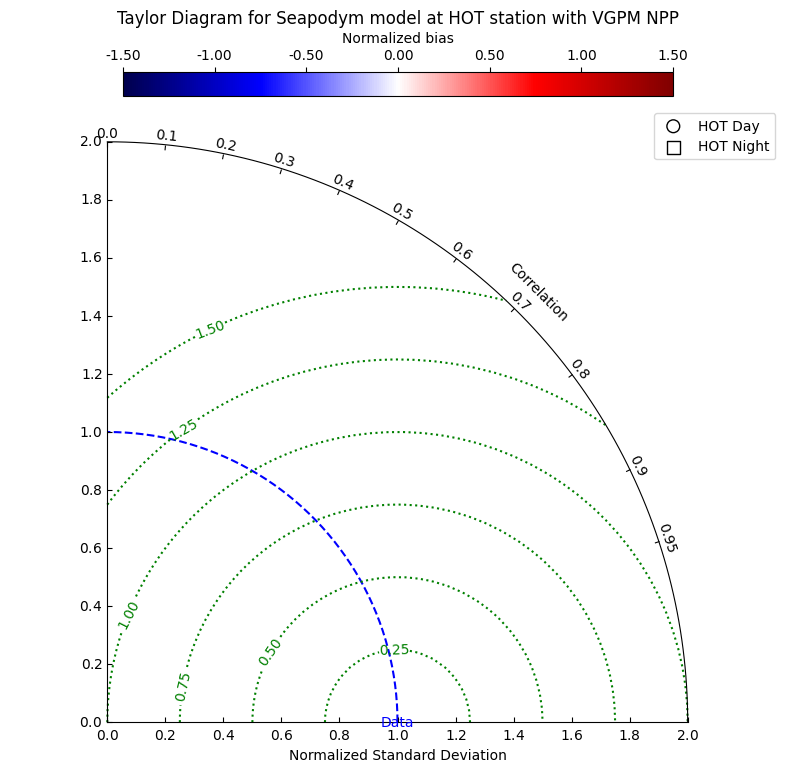

In [16]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred, monthly_pred]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model at HOT station with VGPM NPP")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [17]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,-0.524171,0.580366,-0.301646,1.394721
1,HOT Night,-0.482728,0.459788,-1.512959,1.286588
